In [17]:
import numpy as np
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive

In [2]:
# https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv
df = pd.read_csv('dados/train.csv.zip', date_format='%Y-%m-%d',
                 parse_dates=['date'], index_col='id')

In [3]:
df.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df['store_nbr'].nunique()

54

In [5]:
df1 = df.loc[df['store_nbr'] == 1, ['date', 'family', 'sales']]
df1 = df1.rename(columns={'date': 'ds', 'sales': 'y', 'family':'unique_id'})

In [6]:
df1.head()

,ds,unique_id,y
id,,,
0,2013-01-01,AUTOMOTIVE,0.0
1,2013-01-01,BABY CARE,0.0
2,2013-01-01,BEAUTY,0.0
3,2013-01-01,BEVERAGES,0.0
4,2013-01-01,BOOKS,0.0


In [7]:
train = df1.loc[df1['ds'] < '2014-01-01']
valid = df1.loc[(df1['ds'] >= '2014-01-01') & (df1['ds'] < '2014-04-01')]
h = valid['ds'].nunique()

In [8]:
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(train)

df_pred = model.predict(h=h, level=[90])
df_pred.head()

/Users/edupmon/Library/Python/3.9/lib/python/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,Naive,Naive-lo-90,Naive-hi-90
unique_id,,,,
AUTOMOTIVE,2014-01-01,2.0,-2.671534,6.671534
AUTOMOTIVE,2014-01-02,2.0,-4.606546,8.606546
AUTOMOTIVE,2014-01-03,2.0,-6.091333,10.091333
AUTOMOTIVE,2014-01-04,2.0,-7.343067,11.343067
AUTOMOTIVE,2014-01-05,2.0,-8.445867,12.445867


In [9]:
df_pred = df_pred.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
df_pred.head()

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,y
0,AUTOMOTIVE,2014-01-01,2.0,-2.671534,6.671534,0.0
1,AUTOMOTIVE,2014-01-02,2.0,-4.606546,8.606546,3.0
2,AUTOMOTIVE,2014-01-03,2.0,-6.091333,10.091333,0.0
3,AUTOMOTIVE,2014-01-04,2.0,-7.343067,11.343067,0.0
4,AUTOMOTIVE,2014-01-05,2.0,-8.445867,12.445867,1.0


In [10]:
def wmape(y, y_pred):
    return np.abs(y - y_pred).sum() / np.abs(y).sum()

In [11]:
print('wmape: ', wmape(df_pred['y'].values, df_pred['Naive'].values))

wmape:  0.574998521469236


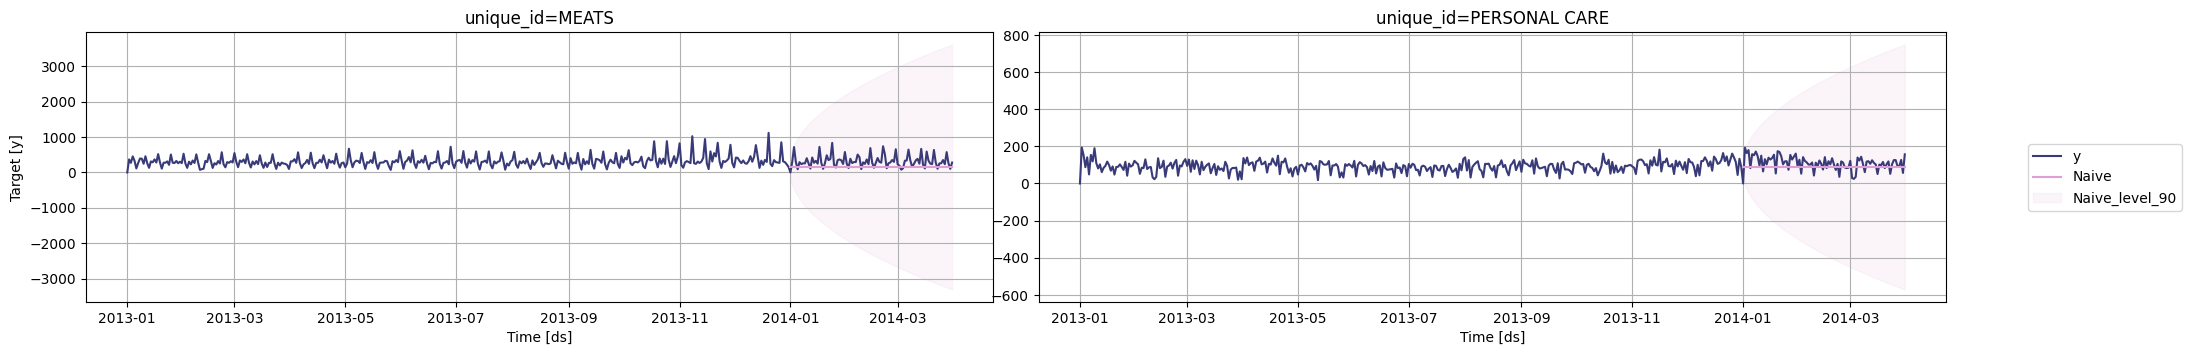

In [12]:
model.plot(train, df_pred, level=[90], unique_ids=['MEATS', 'PERSONAL CARE'])

In [13]:
model_seasonal = StatsForecast(models=[SeasonalNaive(season_length=7)],
                               freq='D', n_jobs=-1)
model_seasonal.fit(train)

df_pred_seasonal = model_seasonal.predict(h=h, level=[90])
df_pred_seasonal.head()

/Users/edupmon/Library/Python/3.9/lib/python/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,
AUTOMOTIVE,2014-01-01,1.0,-15.373032,17.373032
AUTOMOTIVE,2014-01-02,2.0,-14.373032,18.373032
AUTOMOTIVE,2014-01-03,6.0,-10.373032,22.373032
AUTOMOTIVE,2014-01-04,4.0,-12.373032,20.373032
AUTOMOTIVE,2014-01-05,0.0,-16.373032,16.373032


In [14]:
df_pred_seasonal = df_pred_seasonal.reset_index().merge(valid,
                                                        on=['ds', 'unique_id'],
                                                        how='left')
df_pred_seasonal.head()

,unique_id,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,y
0,AUTOMOTIVE,2014-01-01,1.0,-15.373032,17.373032,0.0
1,AUTOMOTIVE,2014-01-02,2.0,-14.373032,18.373032,3.0
2,AUTOMOTIVE,2014-01-03,6.0,-10.373032,22.373032,0.0
3,AUTOMOTIVE,2014-01-04,4.0,-12.373032,20.373032,0.0
4,AUTOMOTIVE,2014-01-05,0.0,-16.373032,16.373032,1.0


In [15]:
print('wmape: ', wmape(df_pred_seasonal['y'].values,
                       df_pred_seasonal['SeasonalNaive'].values))

wmape:  0.5091353262472122


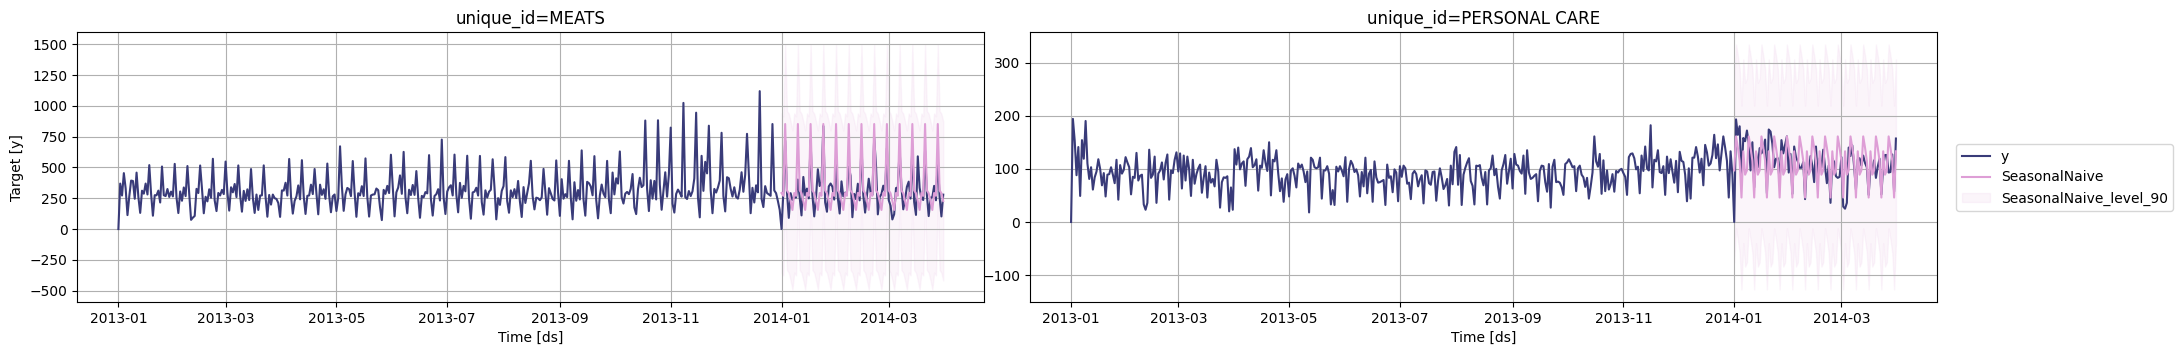

In [16]:
model.plot(train, df_pred_seasonal, level=[90],
           unique_ids=['MEATS', 'PERSONAL CARE'])